自编码器
===

# 1.全局设置

In [7]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

from jjzhk.progressbar import ProgressBar

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

# Hyperparameters
random_seed = 123
learning_rate = 0.005
num_epochs = 5
batch_size = 256

# Architecture
num_features = 784
num_hidden_1 = 32

Device: cuda:0


# 2.导入数据集

In [3]:
train_dataset = datasets.MNIST(root='/input', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='/input', 
                              train=False, 
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)


# 3.模型

In [4]:
##########################
### MODEL
##########################

class Autoencoder(torch.nn.Module):

    def __init__(self, num_features):
        super(Autoencoder, self).__init__()
        
        ### ENCODER
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        # The following to lones are not necessary, 
        # but used here to demonstrate how to access the weights
        # and use a different weight initialization.
        # By default, PyTorch uses Xavier/Glorot initialization, which
        # should usually be preferred.
        self.linear_1.weight.detach().normal_(0.0, 0.1)
        self.linear_1.bias.detach().zero_()
        
        ### DECODER
        self.linear_2 = torch.nn.Linear(num_hidden_1, num_features)
        self.linear_1.weight.detach().normal_(0.0, 0.1)
        self.linear_1.bias.detach().zero_()
        

    def forward(self, x):
        
        ### ENCODER
        encoded = self.linear_1(x)
        encoded = F.leaky_relu(encoded)
        
        ### DECODER
        logits = self.linear_2(encoded)
        decoded = torch.sigmoid(logits)
        
        return decoded

    
torch.manual_seed(random_seed)
model = Autoencoder(num_features=num_features)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

# 4.训练

In [11]:
start_time = time.time()
bar = ProgressBar(num_epochs, len(train_loader), "Loss:%.3f")
for epoch in range(1, num_epochs + 1):
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        # don't need labels, only the images (features)
        features = features.view(-1, 28*28).to(device)
            
        ### FORWARD AND BACK PROP
        decoded = model(features)
        cost = F.binary_cross_entropy(decoded, features)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        bar.show(epoch, cost)

Epoch:1 / 5 [*********************************************************************************************************************] 235 / 235 ,Loss:0.085,total=0:00:100
Epoch:2 / 5 [*********************************************************************************************************************] 235 / 235 ,Loss:0.096,total=0:00:100
Epoch:3 / 5 [*********************************************************************************************************************] 235 / 235 ,Loss:0.099,total=0:00:100
Epoch:4 / 5 [*********************************************************************************************************************] 235 / 235 ,Loss:0.091,total=0:00:100
Epoch:5 / 5 [*********************************************************************************************************************] 235 / 235 ,Loss:0.093,total=0:00:100


# 5.评估

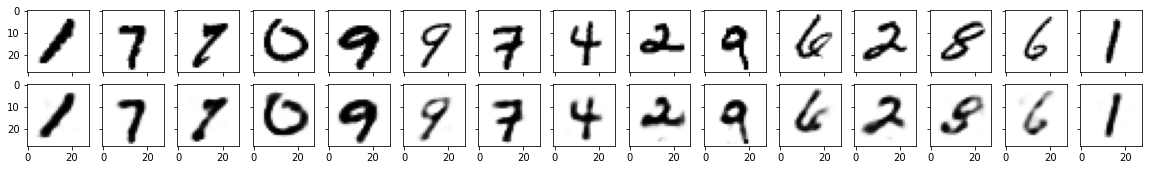

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

##########################
### VISUALIZATION
##########################

n_images = 15
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]
decoded_images = decoded[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        curr_img = img[i].detach().to(torch.device('cpu'))
        ax[i].imshow(curr_img.view((image_width, image_width)), cmap='binary')